In [116]:
# !pip install openblender

In [117]:
import pandas as pd
import numpy as np
import OpenBlender
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [118]:
import os
from dotenv import load_dotenv

Our aim would be to use news data to predict the change in crypto market, i.e whether the crypto price would rise or whether it would fall

In [119]:
# token is the api_token from the OpenBlender website

load_dotenv("env.env")
token = os.getenv("token")
action = os.getenv("action")

In [120]:
# we are using Bitcoin vs USD, which is Daily exchange rate of US dollar vs Bitcoin
parameters = { 
    'token' : token,
    'id_dataset' : '5d4c3af79516290b01c83f51',
    'date_filter':{"start_date" : "2020-05-01",
                   "end_date" : "2021-01-30"} 
}
# reading the json response of the API into pandas dataframe
data = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
data.reset_index(drop=True, inplace=True)
# converting timestamp to date 
data['date'] = [OpenBlender.unixToDate(ts, timezone = 'GMT') for ts in data.timestamp]
data = data.drop('timestamp', axis = 1)

Task ID: '61e0d3cc0895fafb4a9d8d4b'.
Total estimated consumption: 500.02 processing units.
100.0 % completed.


In [121]:
data.head()

,volume,price,high,low,open,change,date
0,14.77K,30454.0,32519.0,29815.0,32519.0,-6.35%,27-01-2021 17:00:00
1,8.54K,32519.0,32735.1,31434.0,32268.1,0.78%,26-01-2021 17:00:00
2,9.23K,32268.1,34693.0,32268.1,32298.0,-0.09%,25-01-2021 17:00:00
3,5.89K,32298.0,32830.0,31481.0,32099.0,0.62%,24-01-2021 17:00:00
4,7.07K,32099.0,33062.0,31773.0,33062.0,-2.91%,23-01-2021 17:00:00


In [122]:
# generate the target variable which is whether the crypto price increased or declined
# we are subtracting the closing price and opening price
data['log_diff'] = np.log(data['price']) - np.log(data['open'])

In [123]:
# let's generate the target variable based on log_diff, if greater than 0, it means rise, if less than 0 it means decline
data['target'] = [1 if log_diff > 0 else 0 for log_diff in data['log_diff']]

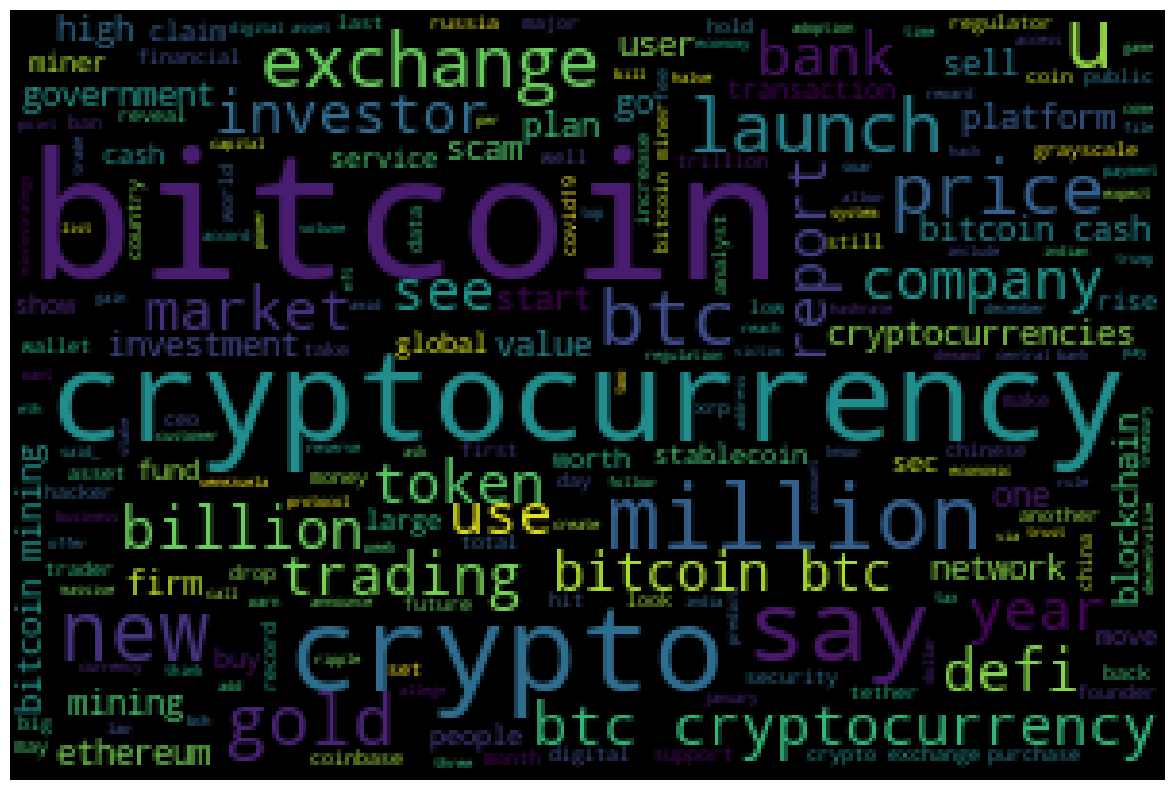

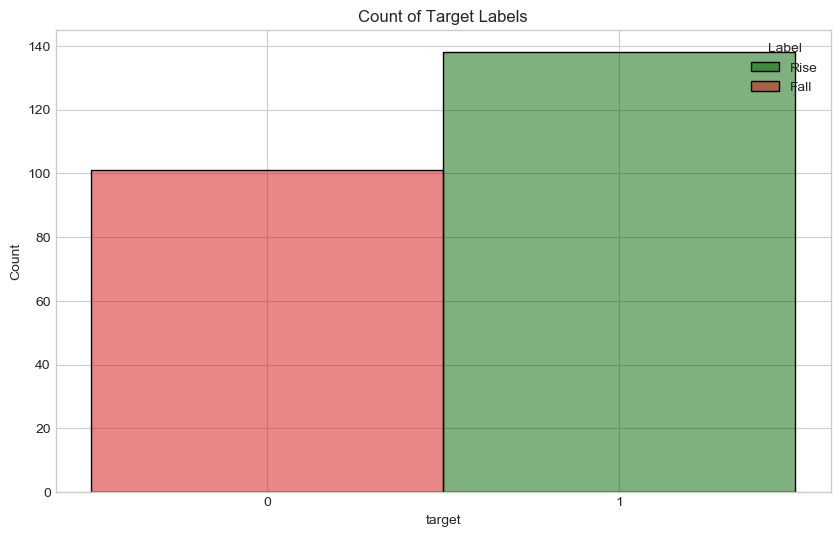

In [124]:
# let's look at the count of the target variables
plt.subplots(figsize=(10,6))
target_data = data.copy()
target_data["target"]=target_data["target"].astype(str)
plot=sns.histplot(data=target_data,x="target",hue="target",palette=["#d1120f","#006400"],legend="target")
plt.title("Count of Target Labels")
plt.legend(title='Label', loc='upper right', labels=['Rise', 'Fall'])
plt.show(plot)


In [125]:
data.head()

,volume,price,high,low,open,change,date,log_diff,target
0,14.77K,30454.0,32519.0,29815.0,32519.0,-6.35%,27-01-2021 17:00:00,-0.065607,0
1,8.54K,32519.0,32735.1,31434.0,32268.1,0.78%,26-01-2021 17:00:00,0.007745,1
2,9.23K,32268.1,34693.0,32268.1,32298.0,-0.09%,25-01-2021 17:00:00,-0.000926,0
3,5.89K,32298.0,32830.0,31481.0,32099.0,0.62%,24-01-2021 17:00:00,0.006180,1
4,7.07K,32099.0,33062.0,31773.0,33062.0,-2.91%,23-01-2021 17:00:00,-0.029560,0


In [126]:
# Now, we want to mix external news data with our bitcoin data, to do so we will time-blend. 
# In other words, it means to outer join the news dataset using the timestamp as key.
format = '%d-%m-%Y %H:%M:%S'
timezone = 'GMT'

# The Unix Timestamp is the number of seconds since 1970 on UTC 
# it is a very preferred format because it is the same in every time zone in the world

data['timestamp'] = OpenBlender.dateToUnix(data['date'], 
                                           date_format = format, 
                                           timezone = timezone)
data = data[['date', 'timestamp', 'price', 'target']]
data.head()

,date,timestamp,price,target
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0


In [127]:
# next step would be to concat the news dataset with our bitcoin price dataset
# We need to add the id of the dataset and the feature we want from the dataset.
# as the crypto market data is daily based we would aggregrate the news on daily basis 
blend_source = {
                'id_dataset':'5ea2039095162936337156c9',
                'feature' : 'text'
            }

# Now, let's 'timeBlend' it to our dataset
data_with_news = OpenBlender.timeBlend( token = token, # API token
                                  anchor_ts = data.timestamp, # our timestamp column,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals', # 'agg_in_intervals' because we want 24 hour interval aggregation
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior',
                                  interval_output = 'list',
                                  missing_values = 'raw')
data = pd.concat([data, data_with_news.loc[:, data_with_news.columns != 'timestamp']], axis = 1)
data.head()

Task ID: '61e0d3cf0895fafb4a9d8d4c'.
Total estimated consumption: 1564.8 processing units.
Task confirmed. Starting download..
100%


,date,timestamp,price,target,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0,24,"[, cryptocurrencies have gained popularity in ..."
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1,20,[zelaapayae uae will now have a crypto debit c...
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0,15,[cashpay ecommerce marketplace powered by cry...
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1,15,[oh look the researcher willy woo said suddenl...
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0,18,"[according to wu, the chinese crypto community..."


BITCOIN_NE.text_COUNT_last1days shows the number of news on that day

In [128]:
# let's save our data for the future use
data.to_csv("Input_data.csv", index = False)

In [129]:
# let's merge our list of news on each day, to one string so that we can tokenize
data["news"] = data["BITCOIN_NE.text_last1days"].apply(lambda x: " ".join(x))

In [130]:
data.head()

,date,timestamp,price,target,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days,news
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0,24,"[, cryptocurrencies have gained popularity in ...",cryptocurrencies have gained popularity in re...
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1,20,[zelaapayae uae will now have a crypto debit c...,zelaapayae uae will now have a crypto debit ca...
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0,15,[cashpay ecommerce marketplace powered by cry...,cashpay ecommerce marketplace powered by cryp...
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1,15,[oh look the researcher willy woo said suddenl...,oh look the researcher willy woo said suddenly...
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0,18,"[according to wu, the chinese crypto community...","according to wu, the chinese crypto community ..."


In [131]:
!pip install gensim

In [132]:
# we will convert our text into vectors using word2vec method, a feature extraction approach
import gensim


tokenized_news = data["news"].apply(lambda x: x.split()) # tokenizing

modelW2v = gensim.models.word2vec.Word2Vec(
            tokenized_news,
            vector_size=200,
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 8, # no.of cores
            seed = 34)

modelW2v.train(tokenized_news, total_examples= len(data["news"]), epochs=30)

(565432, 830070)

In [133]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += modelW2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [134]:
wordvec_arrays = np.zeros((len(tokenized_news), 200))

for i in range(len(tokenized_news)):
    wordvec_arrays[i,:] = word_vector(tokenized_news[i], 200)
    
wordvecDf = pd.DataFrame(wordvec_arrays)
wordvecDf.shape 

(239, 200)

In [135]:
columns_list = ["A"+str(i)for i in range(1,201)]
wordvecDf.columns = columns_list

In [136]:
wordvecDf["target"] = data["target"]

In [137]:
wordvecDf

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A192,A193,A194,A195,A196,A197,A198,A199,A200,target
0,-0.028072,-0.210611,-0.012355,-0.133122,-0.065544,0.003655,-0.263141,0.006699,0.151848,0.083125,...,-0.174224,0.088087,-0.148625,0.174579,0.057691,-0.151120,-0.120022,0.141038,0.097277,0
1,0.035229,-0.204801,0.013428,-0.116010,-0.026776,-0.058350,-0.252529,-0.044162,0.150636,0.060090,...,-0.236695,0.071610,-0.097312,0.182148,0.040554,-0.113621,-0.119115,0.150337,0.095295,1
2,-0.005911,-0.162609,0.001540,-0.094396,-0.034139,0.021577,-0.224428,0.022050,0.148631,0.095248,...,-0.194788,0.129741,-0.176706,0.205015,0.028868,-0.143415,-0.124443,0.087080,0.099630,0
3,-0.029182,-0.167737,0.021160,-0.111090,-0.030644,-0.007133,-0.215137,0.025851,0.146742,0.080302,...,-0.180791,0.091892,-0.131637,0.204855,0.044004,-0.122901,-0.123797,0.140789,0.097446,1
4,-0.006562,-0.187680,0.023281,-0.119493,-0.039002,-0.011452,-0.249103,-0.018683,0.153750,0.077099,...,-0.227825,0.073886,-0.123367,0.163377,0.032426,-0.148008,-0.136079,0.112599,0.118893,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.112272,-0.212769,0.037342,-0.053392,0.060929,-0.016020,-0.172715,-0.087455,0.074920,0.102271,...,-0.179643,0.141992,-0.062028,0.065036,0.027621,-0.161862,-0.067296,0.104150,0.203514,1
235,0.049666,-0.227558,0.046169,-0.119296,0.003482,-0.003970,-0.234579,-0.014043,0.110179,0.052518,...,-0.047704,0.115052,-0.034754,0.115288,0.051846,-0.213759,-0.077847,0.071716,0.215956,0
236,0.138519,-0.221483,0.083386,-0.021974,0.012038,0.091868,-0.294984,-0.049393,0.095980,0.015287,...,-0.256714,0.124823,0.011387,0.241857,0.035976,-0.140318,-0.043286,0.135014,0.082141,0
237,0.151540,-0.247404,0.083426,-0.116814,-0.026607,0.058965,-0.282252,-0.050548,0.133355,0.063059,...,-0.166145,0.147869,-0.009857,0.179099,0.049950,-0.140818,-0.082210,0.097015,0.146894,1


### Building Sentiment Analysis on the news

#### Removing Stop Words

In [138]:
# Load list of stop-words
listStopwords = nltk.corpus.stopwords.words("english")

In [139]:
def removeStopWords(text,listStopwords=None):
    listText = text.split()
    if listStopwords is not None:
        # only select words that aren't in the stopwords list
        listText = [word for word in listText if word not in 
                    listStopwords]
        
    text = " ".join(listText)
    return text
    

In [140]:
# apply the removal of stopwords on each news
data["cleaned_news"] = data["news"].apply(lambda x:removeStopWords(x,listStopwords=listStopwords))

#### Tokenizing the news for Lemmatization

In [141]:
# tokenize the news into words so that we can apply lemmatization
tokenized_news= data['cleaned_news'].apply(lambda x: x.split())

In [142]:
# initialize the lemmatizer and lemmatizr Adjectives, Verbs, Noun and Adverbs
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

wordnetLemmatizer = WordNetLemmatizer()
def getWordnetPos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [143]:
tokenized_news = tokenized_news.apply(lambda x: [wordnetLemmatizer.lemmatize(i,getWordnetPos(i)) for i in x])

# join the tokenized words back again after lemmatization so that we have cleaned news
for i in range(len(tokenized_news)):
    tokenized_news[i]=" ".join(tokenized_news[i])
data['cleaned_news'] = tokenized_news

In [144]:
data.head()

,date,timestamp,price,target,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days,news,cleaned_news
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0,24,"[, cryptocurrencies have gained popularity in ...",cryptocurrencies have gained popularity in re...,cryptocurrencies gain popularity recent years_...
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1,20,[zelaapayae uae will now have a crypto debit c...,zelaapayae uae will now have a crypto debit ca...,zelaapayae uae crypto debit card official obli...
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0,15,[cashpay ecommerce marketplace powered by cry...,cashpay ecommerce marketplace powered by cryp...,cashpay ecommerce marketplace power cryptocurr...
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1,15,[oh look the researcher willy woo said suddenl...,oh look the researcher willy woo said suddenly...,oh look researcher willy woo say suddenly ther...
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0,18,"[according to wu, the chinese crypto community...","according to wu, the chinese crypto community ...","accord wu, chinese crypto community question f..."


#### Applying Sentiment Analysis on the cleaned news 

In [145]:
sid = SentimentIntensityAnalyzer()
data["polarity_scores"] = data["cleaned_news"].apply(lambda x : sid.polarity_scores(x))

the polarity scores contains **Compound Score** which is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

In [146]:
data["compound_scores"] = data["polarity_scores"].apply(lambda x : x.get('compound'))

In [147]:
# let's convert compound scores into positive, neutral and negative class
def get_sentiment_class(compound_score):
    if compound_score >= 0.05 :
        return "Positive"
    elif compound_score <= - 0.05 :
        return "Negative"
    else :
        return "Neutral"

In [148]:
data["sentiment_class"] =  data["compound_scores"].apply(lambda x: get_sentiment_class(x))

In [149]:
data.head()

,date,timestamp,price,target,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days,news,cleaned_news,polarity_scores,compound_scores,sentiment_class
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0,24,"[, cryptocurrencies have gained popularity in ...",cryptocurrencies have gained popularity in re...,cryptocurrencies gain popularity recent years_...,"{'neg': 0.077, 'neu': 0.791, 'pos': 0.132, 'co...",0.9662,Positive
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1,20,[zelaapayae uae will now have a crypto debit c...,zelaapayae uae will now have a crypto debit ca...,zelaapayae uae crypto debit card official obli...,"{'neg': 0.07, 'neu': 0.782, 'pos': 0.148, 'com...",0.9633,Positive
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0,15,[cashpay ecommerce marketplace powered by cry...,cashpay ecommerce marketplace powered by cryp...,cashpay ecommerce marketplace power cryptocurr...,"{'neg': 0.073, 'neu': 0.82, 'pos': 0.107, 'com...",0.8789,Positive
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1,15,[oh look the researcher willy woo said suddenl...,oh look the researcher willy woo said suddenly...,oh look researcher willy woo say suddenly ther...,"{'neg': 0.071, 'neu': 0.761, 'pos': 0.168, 'co...",0.9712,Positive
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0,18,"[according to wu, the chinese crypto community...","according to wu, the chinese crypto community ...","accord wu, chinese crypto community question f...","{'neg': 0.059, 'neu': 0.837, 'pos': 0.104, 'co...",0.8402,Positive


#### correlation between compound scores and our target variable

In [150]:
data[["target", "compound_scores"]].corr()

,target,compound_scores
target,1.000000,0.038556
compound_scores,0.038556,1.000000


there seems to be very little correlation between the target variable and the sentiment of our daily news

### Build Models

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score

In [152]:
# splitting data into training and validation set
xtrain, xvalid, ytrain, yvalid = train_test_split(wordvecDf,wordvecDf['target'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [153]:
# build a random forest model
random_forest_model = RandomForestClassifier().fit(xtrain, ytrain)
prediction = random_forest_model.predict(xvalid)
print("Accuracy score",accuracy_score(yvalid, prediction))

Accuracy score 0.9583333333333334


In [154]:
# !pip install wordcloud

In [155]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [156]:
tokenized_news

0      cryptocurrencies gain popularity recent years_...
1      zelaapayae uae crypto debit card official obli...
2      cashpay ecommerce marketplace power cryptocurr...
3      oh look researcher willy woo say suddenly ther...
4      accord wu, chinese crypto community question f...
                             ...                        
234    u treasury borrow 3 trillion single quarter an...
235    u real estate market shudder expert predict 40...
236    bitcoin sextortion scam use email video passwo...
237    cointracking launch two powerful free plugins ...
238    bitcoin lender genesis global issue 2 billion ...
Name: cleaned_news, Length: 239, dtype: object

In [157]:
a = [x.split() for x in tokenized_news]

In [158]:
d = []
for x in a:
    d += x

In [159]:
def show_cloud(w_list, title=""):
    words = WordCloud(width=300).generate(" ".join(w_list))
    plt.imshow(words)
    plt.axis("off")
    plt.title(title)
    plt.show()

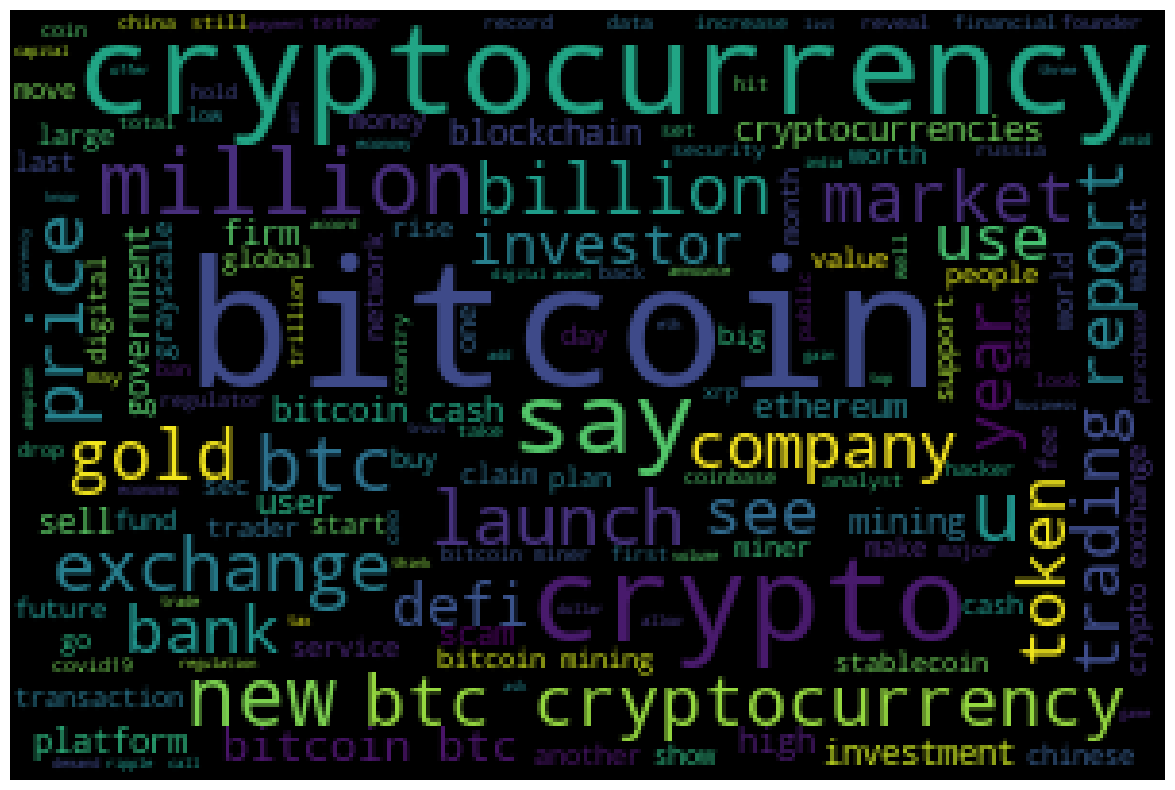

In [160]:
show_cloud(d)

In [161]:
words = WordCloud(width=300).generate(" ".join(d))

In [162]:
words